# Downloading Fastai and Other Requirements

In [0]:
!pip install fastai==0.7.0
# !pip install kaggle
# !pip install -U -q PyDrive

     |████████████████████████████████| 122kB 6.6MB/s 
     |████████████████████████████████| 496.4MB 51kB/s 
     |████████████████████████████████| 1.5MB 39.3MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl size=2667025 sha256=9053c774e97aa8b30ad4e83b8902980c0e776141c035e30753fe12a2b4085918
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
ERROR: torchvision 0.4.0 has requirement torch==1.2.0, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: torch 1.2.0
    Uninstalling torch-1.2.0:
      Successfully uninstalled torch-1.2.0
  Found existing installation: fastai 1.0.57
    Uninstalling fastai-1.0.57:
      Successfully uninstalled fastai-1.0.57


# Importing Colab Related Packages

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn import preprocessing 
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
from google.colab import files
import zipfile
import shutil

# FastAi Related Packages

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics

# Helper Functions

In [0]:
def mount_drive():
  from google.colab import drive
  drive.mount('/content/gdrive')
def downloadDatasetFromKaggle():
  #first upload kaggle.json
  files.upload()

  #before importing the dataset we want to use this code
  # The Kaggle API client expects this file to be in ~/.kaggle,
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/

  # This permissions change avoids a warning on Kaggle tool startup.
  !chmod 600 ~/.kaggle/kaggle.json


  !kaggle competitions download -c bluebook-for-bulldozers

def unzip(path_of_file , path_to_extract):
  with zipfile.ZipFile(path_of_file , 'r') as zip:
    zip.extractall(path_to_extract)

def moveFile(move_from , move_to):
  shutil.move(move_from , move_to)

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
  res = [rmse(m.predict(X_train),y_train), rmse(m.predict(X_valid), y_valid)
          , m.score(X_train,y_train), m.score(X_valid, y_valid)]

  if hasattr(m, 'oob_score_'): res.append(m.oob_score_)

  print(res)

def split_vals(a, n): return a[:n].copy(), a[n:].copy()

In [0]:
mount_drive()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Main Code Starts

In [0]:
PATH = "/content/gdrive/My Drive/fastai/"

In [0]:
?pd.read_csv

## Read Data

In [0]:
df_raw = pd.read_csv(f'{PATH}data/Train.csv',low_memory=False,parse_dates=['saledate'])

In [0]:
df_raw.head() #or display()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df_raw.shape

(401125, 53)

## Change Data into its Log

In [0]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [0]:
df_raw.saledate

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
5        2008-12-18
6        2004-08-26
7        2005-11-17
8        2009-08-27
9        2007-08-09
10       2008-08-21
11       2006-08-24
12       2005-10-20
13       2006-01-26
14       2006-01-03
15       2006-11-16
16       2007-06-14
17       2010-01-28
18       2006-03-09
19       2005-11-17
20       2006-05-18
21       2006-10-19
22       2007-10-25
23       2006-10-19
24       2004-05-20
25       2006-03-09
26       2006-03-09
27       2007-02-22
28       2007-08-09
29       2006-06-01
            ...    
401095   2011-12-14
401096   2011-09-15
401097   2011-10-28
401098   2011-08-16
401099   2011-12-14
401100   2011-08-16
401101   2011-12-14
401102   2011-08-16
401103   2011-09-15
401104   2011-08-16
401105   2011-10-25
401106   2011-08-16
401107   2011-09-15
401108   2011-08-16
401109   2011-08-16
401110   2011-09-15
401111   2011-10-25
401112   2011-10-25
401113   2011-10-25


## Add Data Related Columns using add_datepart()

In [0]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [0]:
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


In [0]:
?train_cats

## Change String Columns into Catetorial Columns

In [0]:
train_cats(df_raw)

In [0]:
for col in df_raw.columns:
  try:
    print(col," : ", df_raw[col].cat.categories)
  except:
    print(col , " is not numeric Col")



### Change order of Category in UsageBand Columns

In [0]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

#### Print % of emptyness of each Columns

In [0]:
df_raw.isnull().sum().sort_index()/len(df_raw)

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

## Save Data in Feather Form

In [0]:
os.makedirs(f'{PATH}tmp' , exist_ok=True)
df_raw.to_feather(f'{PATH}tmp/raw')

## Load Data from Feather form

In [0]:
df_raw = pd.read_feather(f'{PATH}tmp/raw')

In [0]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2006,11,46,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2004,3,13,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,2,9,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,5,20,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,7,30,23,3,204,False,False,False,False,False,False,1248307200


## Filling the na values

In [0]:
?proc_df

In [0]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [0]:
nas

{'MachineHoursCurrentMeter': 0.0, 'auctioneerID': 2.0}

In [0]:
df.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleI

## Processing

In [0]:
RFRegressor = RandomForestRegressor(n_jobs=-1)
RFRegressor.fit(df, y)
RFRegressor.score(df, y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9830885495996704

In [0]:
n_valid = 12000
n_train = len(df) - n_valid
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [0]:
model = RandomForestRegressor(n_jobs= -1)
%time model.fit(X_train, y_train)
print_score(model)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 38s, sys: 360 ms, total: 1min 38s
Wall time: 50.8 s
[0.09067521295432569, 0.2527235349571039, 0.9828164854684377, 0.8859384289300243]


### Speeding things up

In [0]:
df_trn, y_trn,_ = proc_df(df_raw, 'SalePrice', subset=30000) #Random Subset
X_train, _ = split_vals(df_trn,20000)
y_train, _ = split_vals(y_trn, 20000)

In [0]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
17,1139299,1002713,21442,121,3.0,2003,0.0,0,878,264,106,0,0,5,20,52,4,4,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,2,3,29,3,2,1,0,0,0,0,0,2010,1,4,28,3,28,False,False,False,False,False,False,1264636800,False,False
38,1139401,1011478,18604,121,3.0,2003,0.0,0,1891,634,0,0,0,0,42,24,3,3,0,6,2,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,2,3,0,0,0,0,0,0,0,0,0,0,0,2009,7,30,24,4,205,False,False,False,False,False,False,1248393600,False,False
46,1139424,1011821,4818,121,3.0,1000,5074.0,3,1424,412,15,0,0,0,33,15,2,2,1,3,0,0,0,0,6,0,1,3,3,1,5,1,2,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010,11,46,18,3,322,False,False,False,False,False,False,1290038400,False,False
63,1139473,1054162,663,121,3.0,2000,1894.0,2,4870,1877,0,14,0,0,3,25,1,1,2,3,1,2,1,1,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2004,6,25,15,1,167,False,False,False,False,False,False,1087257600,False,False
67,1139481,1062393,13247,121,3.0,2005,2032.0,2,1066,324,91,98,0,0,2,44,1,1,4,6,1,2,1,2,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010,4,16,22,3,112,False,False,False,False,False,False,1271894400,False,False


In [0]:
df_trn.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
17,1139299,1002713,21442,121,3.0,2003,0.0,0,878,264,106,0,0,5,20,52,4,4,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,2,3,29,3,2,1,0,0,0,0,0,2010,1,4,28,3,28,False,False,False,False,False,False,1264636800,False,False
38,1139401,1011478,18604,121,3.0,2003,0.0,0,1891,634,0,0,0,0,42,24,3,3,0,6,2,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,2,3,0,0,0,0,0,0,0,0,0,0,0,2009,7,30,24,4,205,False,False,False,False,False,False,1248393600,False,False
46,1139424,1011821,4818,121,3.0,1000,5074.0,3,1424,412,15,0,0,0,33,15,2,2,1,3,0,0,0,0,6,0,1,3,3,1,5,1,2,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010,11,46,18,3,322,False,False,False,False,False,False,1290038400,False,False
63,1139473,1054162,663,121,3.0,2000,1894.0,2,4870,1877,0,14,0,0,3,25,1,1,2,3,1,2,1,1,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2004,6,25,15,1,167,False,False,False,False,False,False,1087257600,False,False
67,1139481,1062393,13247,121,3.0,2005,2032.0,2,1066,324,91,98,0,0,2,44,1,1,4,6,1,2,1,2,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2010,4,16,22,3,112,False,False,False,False,False,False,1271894400,False,False


In [0]:
model = RandomForestRegressor(n_jobs=-1)
%time model.fit(X_train, y_train)
print_score(model)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 4.08 s, sys: 10.8 ms, total: 4.09 s
Wall time: 2.18 s
[0.11229820901006607, 0.3634287551058247, 0.9725950501388998, 0.764122483307696]


### Using Single Tree

In [0]:
model = RandomForestRegressor(n_estimators=1,max_depth=3, bootstrap=False, n_jobs=-1)
model.fit(X_train,y_train)
print_score(model)

[0.5223423495266699, 0.5810173772888333, 0.4070831013049919, 0.3971264682446839]


### Bagging

In [0]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train,y_train)
print_score(model)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.09017687401097725, 0.24798693777296968, 0.9830048430813062, 0.8901738939715479]


In [0]:
preds = np.array([t.predict(X_valid) for t in model.estimators_])
print(preds[:1]  , sep=" ") 
np.mean(preds[:1]) , y_valid[0]


[[9.21034 8.9872  9.09381 ... 9.43348 9.21034 9.21034]]


(10.01562601581563, 9.104979856318357)

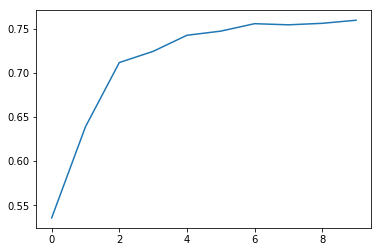

In [0]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1],axis=0)) for i in range(10)])

In [0]:
model = RandomForestRegressor(n_estimators=20, n_jobs=-1)
model.fit(X_train,y_train)
print_score(model)

[0.1037042996493354, 0.3593395392921462, 0.9766290224777461, 0.7694006985774223]


In [0]:
model = RandomForestRegressor(n_estimators=40, n_jobs=-1)
model.fit(X_train,y_train)
print_score(model)

[0.09694913802406846, 0.35438603249415496, 0.9795745677427521, 0.7757145156413539]


In [0]:
model = RandomForestRegressor(n_estimators=20, n_jobs=-1 , oob_score=True)
model.fit(X_train,y_train)
print_score(model)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.10160529839028286, 0.35453094962451176, 0.9775655171343045, 0.7755310464784047, 0.8082749209811046]


## subsampling

In [0]:
df_trn, y_trn,_ = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_train)
y_train, y_valid = split_vals(y_trn, n_train)

In [0]:
??set_rf_samples

In [0]:
set_rf_samples(20000)

In [0]:
model = RandomForestRegressor(n_jobs=-1,oob_score=False)
%time model.fit(X_train, y_train)
print_score(model)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 8.46 s, sys: 64.5 ms, total: 8.52 s
Wall time: 4.98 s
[0.24041437917878358, 0.2782392489530003, 0.8792031235250007, 0.8617437545715629]


In [0]:
model = RandomForestRegressor(n_estimators=40, n_jobs=-1,oob_score=False)
%time model.fit(X_train, y_train)
print_score(model)

CPU times: user 30.4 s, sys: 95.2 ms, total: 30.5 s
Wall time: 16.2 s
[0.22683005097476222, 0.26192438510705884, 0.8924684250134399, 0.8774820165466329]


### Parameter Tuning


In [0]:
reset_rf_samples()

In [0]:
model = RandomForestRegressor(n_estimators=40,n_jobs=-1 , oob_score=True)
model.fit(X_train,y_train)
print_score(model)

[0.07837508441555295, 0.23673624804437665, 0.9871621922029895, 0.8999130408535977, 0.9085294844098059]


In [0]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,n_jobs=-1 , oob_score=True)
model.fit(X_train,y_train)
print_score(model)

[0.1151081976204228, 0.23361748514304861, 0.972308445662299, 0.9025327611743149, 0.908332262213297]


In [0]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,n_jobs=-1 , oob_score=True)
model.fit(X_train,y_train)
print_score(model)

[0.11917342391391324, 0.2287839880326188, 0.9703179658685334, 0.9065241923610714, 0.9115930537352609]


In [0]:
??proc_df

In [0]:
###Keacture 3

### Set random Forent Sample Value to 50000 

In [0]:
set_rf_samples(50000)

In [0]:
model = RandomForestRegressor(n_estimators=40
                              , min_samples_leaf=3
                              , max_features=0.5
                              , n_jobs=-1
                              ,oob_score=True)
model.fit(X_train, y_train)
print_score(model)

[0.20577055857303866, 0.2514873797671597, 0.9115085525140193, 0.887051526445136, 0.894557362725563]


In [0]:
## Slow 

%time preds = np.array([t.predict(X_valid) for t in model.estimators_])
np.mean(preds[:,0]) , np.std(preds[:,0])

CPU times: user 1.44 s, sys: 61 ms, total: 1.5 s
Wall time: 1.51 s


(9.321118891482957, 0.2790267249992271)

In [0]:
??parallel_trees

In [0]:
## Fast Version

def get_preds(t): return t.predict(X_valid)
%time preds = np.array(parallel_trees(model, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 116 ms, sys: 141 ms, total: 257 ms
Wall time: 1.73 s


(9.321118891482957, 0.2790267249992271)

In [0]:
raw_train, raw_valid = split_vals(df_raw, n_train)

In [0]:
raw_train.shape

(389125, 65)

### Data Analysis

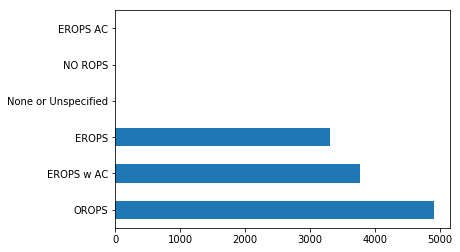

In [0]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh()

In [0]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure' , as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.835543,0.275867
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.573826,0.266127
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.684221,0.223729


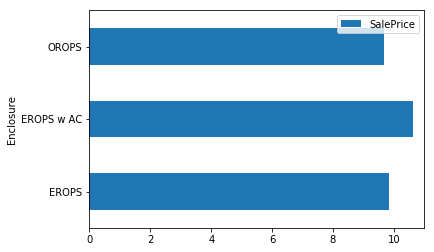

In [0]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh' , xlim=(0,11))

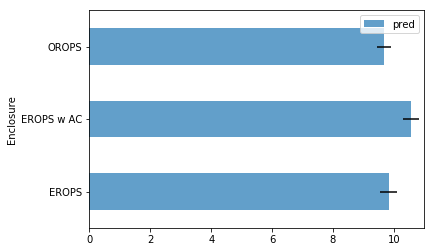

In [0]:
enc_summ.plot('Enclosure' 
               ,'pred'
               ,'barh'
               ,xerr='pred_std'
               ,alpha=0.7
              ,xlim=(0,11))

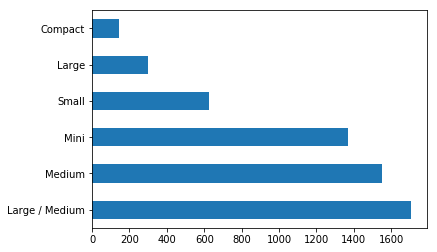

In [0]:
raw_valid.ProductSize.value_counts().plot.barh()

In [0]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby('ProductSize').mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.888973,0.363185
Large,10.470589,10.373369,0.367073
Large / Medium,10.691871,10.646232,0.297745
Medium,10.681511,10.619367,0.288889
Mini,9.535147,9.555243,0.249900
Small,10.324448,10.321587,0.304898


In [0]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.036726
Large             0.035386
Small             0.029540
Large / Medium    0.027967
Medium            0.027204
Mini              0.026153
dtype: float64

## Feature Importance

In [0]:
fi = rf_feat_importance(model, df); fi[:10]

,cols,imp
5,YearMade,0.172483
37,Coupler_System,0.109590
13,ProductSize,0.107813
14,fiProductClassDesc,0.075682
38,Grouser_Tracks,0.056192
2,ModelID,0.054267
63,saleElapsed,0.049844
10,fiSecondaryDesc,0.046299
19,Enclosure,0.033281
8,fiModelDesc,0.033029


In [0]:
def plot_fi(fi): return fi.plot('cols'
                                ,'imp'
                                ,'barh'
                                ,figsize=(12,7)
                                ,legend=False
                                )

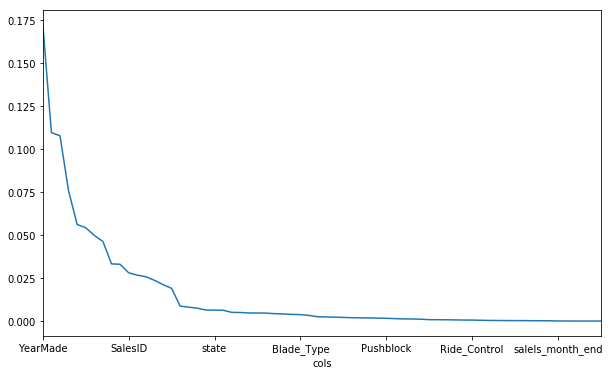

In [0]:
fi.plot('cols', 'imp' , figsize=(10,6) ,legend=False)

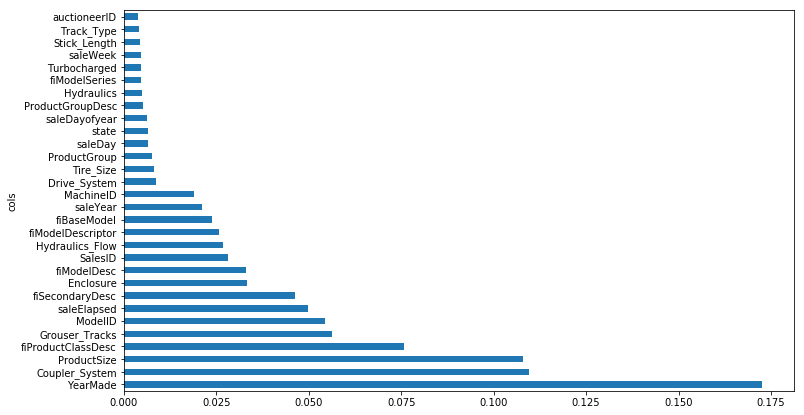

In [0]:
fi[:30].plot('cols','imp', 'barh', figsize=(12,7), legend=False)

In [0]:
to_keep = fi[fi.imp > 0.005].cols; len(to_keep)

23

In [0]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_train)

In [0]:
model = RandomForestRegressor(n_estimators=40
                              ,min_samples_leaf=3
                              ,max_features=0.5
                              ,n_jobs=-1
                              ,oob_score=True
                              )
model.fit(X_train, y_train)
print_score(model)

[0.20723840579990485, 0.2472818926100975, 0.9102415567558142, 0.8907974936864635, 0.8939330604058289]


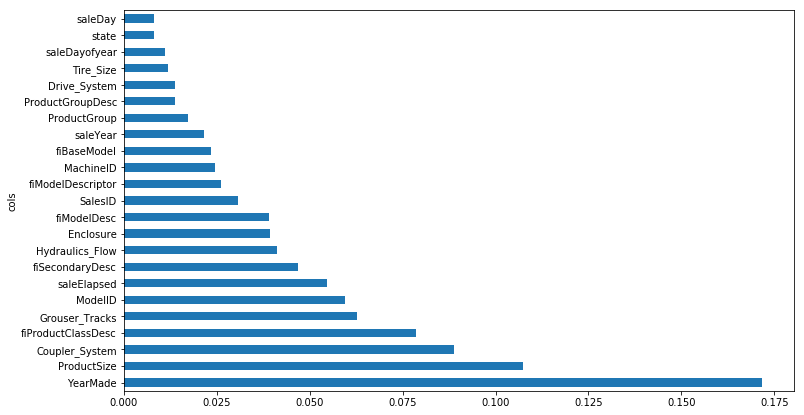

In [0]:
fi = rf_feat_importance(model, df_keep)
plot_fi(fi)